In [ ]:
# Ray aDAG Developer Guide - Hands-on Walkthrough

## 1. Introduction to Ray aDAGs
# Note: Transition to slides to explain "What is Ray aDAG?" and "Why Use aDAGs?"
# (Discuss performance benefits and specific use cases like LLM inference.)

# Also note that this requires both torch and ray installed (obviously) but both are prepped already as part of the image 
# for Ray Summit Training 2024

In [1]:
# Step 2: Define and Create Actors with Ray Core
import ray

@ray.remote
class EchoActor:
    def echo(self, msg):
        return msg

# Create two actors
a = EchoActor.remote()
b = EchoActor.remote()

2024-09-30 17:54:16,246	INFO worker.py:1601 -- Connecting to existing Ray cluster at address: 10.0.138.179:6379...
2024-09-30 17:54:16,253	INFO worker.py:1777 -- Connected to Ray cluster. View the dashboard at https://session-bimi5q6im9gb2znrbq9siuvzkr.i.anyscaleuserdata.com 
2024-09-30 17:54:16,261	INFO packaging.py:359 -- Pushing file package 'gcs://_ray_pkg_14502321ab26dd8c884e1a040236a348b01f05bf.zip' (0.33MiB) to Ray cluster...
2024-09-30 17:54:16,264	INFO packaging.py:372 -- Successfully pushed file package 'gcs://_ray_pkg_14502321ab26dd8c884e1a040236a348b01f05bf.zip'.
(GPUReceiver pid=13065, ip=10.0.131.8) /home/ray/anaconda3/lib/python3.11/site-packages/ray/experimental/channel/serialization_context.py:115: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor

(autoscaler +9m17s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


In [2]:
# Send a message and get a response
msg_ref = a.echo.remote("hello")
msg_ref = b.echo.remote(msg_ref)
print(ray.get(msg_ref))  # Expected output: "hello"

hello


In [3]:
## 3. Using Ray aDAGs for Performance Optimization
# Note: Transition to slides to explain "How Ray Core traditionally executes tasks" 
# and "Challenges with dynamic control flow" (discuss overheads with serialization and object store).

# Step 3: Define and Execute with Ray DAG API (Classic Ray Core)
import ray.dag
import time

In [4]:
# Define a lazy DAG
with ray.dag.InputNode() as inp:
    intermediate_inp = a.echo.bind(inp)
    dag = b.echo.bind(intermediate_inp)

In [5]:
# Execute the DAG with inputs
print(ray.get(dag.execute("hello")))
print(ray.get(dag.execute("world")))

hello
world


In [6]:
# Time the execution
for _ in range(5):
    start = time.perf_counter()
    ray.get(dag.execute("hello"))
    print("Took", time.perf_counter() - start)

Took 0.003645734000201628
Took 0.002077852000184066
Took 0.002066164999632747
Took 0.0019400420005695196
Took 0.0019085539997831802


In [7]:
## 4. Optimizing with Ray aDAGs

# Step 4: Compile and Execute with aDAG Backend and time and compare the difference in exec speed
adag = dag.experimental_compile()

In [8]:
# Execute the aDAG and measure the time
for _ in range(5):
    start = time.perf_counter()
    ray.get(adag.execute("hello"))
    print("Took", time.perf_counter() - start)

Took 0.0031345869992946973
Took 0.0006918250001035631
Took 0.000573442000131763
Took 0.0005373019994294737
Took 0.0005289509999784059


In [11]:
from ray.dag import plot

In [ ]:
# pip install pydot
!sudo apt install -y graphviz

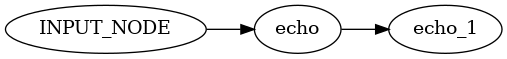

In [12]:
plot(dag)

In [13]:
# Tear down the DAG
adag.teardown()

2024-09-30 17:55:08,943	INFO compiled_dag_node.py:1787 -- Tearing down compiled DAG
2024-09-30 17:55:08,944	INFO compiled_dag_node.py:1793 -- Cancelling compiled worker on actor: Actor(EchoActor, 3272e406721d330e8b0589ce06000000)
2024-09-30 17:55:08,944	INFO compiled_dag_node.py:1793 -- Cancelling compiled worker on actor: Actor(EchoActor, e6a73d523de68793e8458ef306000000)
2024-09-30 17:55:08,948	INFO compiled_dag_node.py:1812 -- Waiting for worker tasks to exit
2024-09-30 17:55:08,949	INFO compiled_dag_node.py:1814 -- Teardown complete


In [14]:
## 5. [BONUS #1] Multi-Actor Execution in Ray aDAG

# Step 5: Executing Across Multiple Actors with Ray aDAG
# Create multiple actors
N = 3
actors = [EchoActor.remote() for _ in range(N)]


In [15]:

# Define the DAG with multiple outputs
with ray.dag.InputNode() as inp:
    outputs = [actor.echo.bind(inp) for actor in actors]
    dag = ray.dag.MultiOutputNode(outputs)


In [16]:

# Compile and execute the DAG
adag = dag.experimental_compile()
print(ray.get(adag.execute("hello")))  # Expected: ["hello", "hello", "hello"]


ValueError: All reader actors must be on the same node. Actor Actor(EchoActor, a6608f2532f37c091ccf747b06000000) is on node 664d4480a4b87323a60cbb7e0cbf6c03f7f3a7f8ed65b9a2efb3bc67 while actor Actor(EchoActor, c07bd99e5dad129b81fc02c706000000) is on node 3d431779794ccc040744af2e893751f59e8163e5a3ece710c46c29e9.

In [18]:

# Tear down the DAG
adag.teardown()



In [19]:
## 6. [BONUS #2] GPU-GPU Communication with aDAGs

# Note: Transition to slides to discuss "GPU-GPU communication and NCCL".

# Step 6: GPU to GPU Data Transfer Example
import torch
from ray.experimental.channel.torch_tensor_type import TorchTensorType

@ray.remote(num_gpus=1)
class GPUSender:
    def send(self, shape):
        return torch.zeros(shape, device="cuda")
@ray.remote(num_gpus=1)
class GPUReceiver:
    def recv(self, tensor: torch.Tensor):
        assert tensor.device.type == "cuda"
        return tensor.shape


In [20]:
# Create the sender and receiver actors
sender = GPUSender.remote()
receiver = GPUReceiver.remote()


In [21]:
# Define and compile a DAG for GPU-GPU communication
with ray.dag.InputNode() as inp:
    dag = sender.send.bind(inp)
    dag = dag.with_type_hint(TorchTensorType())
    dag = receiver.recv.bind(dag)
adag = dag.experimental_compile()


In [22]:
# Execute the DAG and check the results
assert ray.get(adag.execute((10, ))) == (10, )
adag.teardown()

## 7. Conclusion and Summary
# Note: Transition to slides for summarizing key takeaways and discussing 
# limitations of aDAGs (e.g., actor constraints, NCCL).

2024-09-30 17:55:37,441	INFO compiled_dag_node.py:1787 -- Tearing down compiled DAG
2024-09-30 17:55:37,442	INFO compiled_dag_node.py:1793 -- Cancelling compiled worker on actor: Actor(GPUReceiver, f83fbaa6a6d83447ca8e8c4206000000)
2024-09-30 17:55:37,442	INFO compiled_dag_node.py:1793 -- Cancelling compiled worker on actor: Actor(GPUSender, 8c90a6fe8b0cfc54b76278fb06000000)
2024-09-30 17:55:37,446	INFO compiled_dag_node.py:1812 -- Waiting for worker tasks to exit
2024-09-30 17:55:37,447	INFO compiled_dag_node.py:1814 -- Teardown complete


In [23]:
# Send a message and get a response
msg_ref = a.echo.remote("hello")
msg_ref = b.echo.remote(msg_ref)
print(ray.get(msg_ref))  # Expected output: "hello"
## 3. Using Ray aDAGs for Performance Optimization

# Note: Transition to slides to explain "How Ray Core traditionally executes tasks" 
# and "Challenges with dynamic control flow" (discuss overheads with serialization and object store).
# Step 3: Define and Execute with Ray DAG API (Classic Ray Core)
import ray.dag
import time

# Define a lazy DAG
with ray.dag.InputNode() as inp:
    intermediate_inp = a.echo.bind(inp)
    dag = b.echo.bind(intermediate_inp)
# Execute the DAG with inputs
print(ray.get(dag.execute("hello")))
print(ray.get(dag.execute("world")))
# Time the execution
for _ in range(5):
    start = time.perf_counter()
    ray.get(dag.execute("hello"))
    print("Took", time.perf_counter() - start)
## 4. Optimizing with Ray aDAGs

# Step 4: Compile and Execute with aDAG Backend
# Compile the DAG for aDAG backend

adag = dag.experimental_compile()
# Execute the aDAG and measure the time
for _ in range(5):
    start = time.perf_counter()
    ray.get(adag.execute("hello"))
    print("Took", time.perf_counter() - start)
# Tear down the DAG
adag.teardown()

## 5. [BONUS #1] Multi-Actor Execution in Ray aDAG

# Step 5: Executing Across Multiple Actors with Ray aDAG
# Create multiple actors
N = 3
actors = [EchoActor.remote() for _ in range(N)]
# Define the DAG with multiple outputs
with ray.dag.InputNode() as inp:
    outputs = [actor.echo.bind(inp) for actor in actors]
    dag = ray.dag.MultiOutputNode(outputs)
# Compile and execute the DAG
adag = dag.experimental_compile()
print(ray.get(adag.execute("hello")))  # Expected: ["hello", "hello", "hello"]
# Tear down the DAG
adag.teardown()

## 6. [BONUS #2] GPU-GPU Communication with aDAGs

# Note: Transition to slides to discuss "GPU-GPU communication and NCCL".

# Step 6: GPU to GPU Data Transfer Example
import torch
from ray.experimental.channel.torch_tensor_type import TorchTensorType

@ray.remote(num_gpus=1)
class GPUSender:
    def send(self, shape):
        return torch.zeros(shape, device="cuda")
@ray.remote(num_gpus=1)
class GPUReceiver:
    def recv(self, tensor: torch.Tensor):
        assert tensor.device.type == "cuda"
        return tensor.shape
# Create the sender and receiver actors
sender = GPUSender.remote()
receiver = GPUReceiver.remote()
# Define and compile a DAG for GPU-GPU communication
with ray.dag.InputNode() as inp:
    dag = sender.send.bind(inp)
    dag = dag.with_type_hint(TorchTensorType())
    dag = receiver.recv.bind(dag)
adag = dag.experimental_compile()
# Execute the DAG and check the results
assert ray.get(adag.execute((10, ))) == (10, )
adag.teardown()

#

hello
hello
world
Took 0.0018126659997506067
Took 0.0017954260001715738
Took 0.0017651680000199121
Took 0.0017315570003120229
Took 0.0018116640003427165


2024-09-30 17:55:38,691	INFO compiled_dag_node.py:1787 -- Tearing down compiled DAG
2024-09-30 17:55:38,692	INFO compiled_dag_node.py:1793 -- Cancelling compiled worker on actor: Actor(EchoActor, 3272e406721d330e8b0589ce06000000)
2024-09-30 17:55:38,692	INFO compiled_dag_node.py:1793 -- Cancelling compiled worker on actor: Actor(EchoActor, e6a73d523de68793e8458ef306000000)
2024-09-30 17:55:38,695	INFO compiled_dag_node.py:1812 -- Waiting for worker tasks to exit
2024-09-30 17:55:38,696	INFO compiled_dag_node.py:1814 -- Teardown complete


Took 0.0025822930001595523
Took 0.000752711000131967
Took 0.0006054590003259364
Took 0.0005476650003402028
Took 0.0005546590000449214


ValueError: All reader actors must be on the same node. Actor Actor(EchoActor, 6bc658b0e62fff026a6734a106000000) is on node 664d4480a4b87323a60cbb7e0cbf6c03f7f3a7f8ed65b9a2efb3bc67 while actor Actor(EchoActor, 5fe6e767b52538996021b72006000000) is on node 3d431779794ccc040744af2e893751f59e8163e5a3ece710c46c29e9.

In [ ]:
# 7. Conclusion and Summary
# Note: Transition to slides for summarizing key takeaways and discussing 
# limitations of aDAGs (e.g., actor constraints, NCCL).